# Project

__[Project Page](https://notes.teklia.com/s/AU3AEfOBr#)__

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

In [4]:
firstname_with_sex = pd.read_csv('firstname_with_sex.csv', sep=';')
transcriptions_with_sex = pd.read_csv('transcriptions_with_sex.csv', sep=',')
#transcriptions_with_sex = pd.read_csv('transcriptions_with_sex.csv', sep=';|:')

In [5]:
firstname_with_sex

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951
...,...,...,...
6941,winnocq,10,0
6942,xyste,9,1
6943,zara,0,10
6944,zéraphin,10,0


In [6]:
firstname_with_sex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   firstname  6946 non-null   object
 1   male       6946 non-null   int64 
 2   female     6946 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 162.9+ KB


In [7]:
# A ratio closer to 1 means a name more used by males
firstname_with_sex['ratio'] = firstname_with_sex['male'] / (firstname_with_sex['male'] + firstname_with_sex['female'])

In [8]:
firstname_with_sex.head()

,firstname,male,female,ratio
0,marie,10145,2390322,0.004226
1,jean,1869615,6476,0.996548
2,pierre,1475841,5047,0.996592
3,jeanne,1765,1097397,0.001606
4,françois,1089009,5951,0.994565


### Descriptive Statistics

<AxesSubplot:>

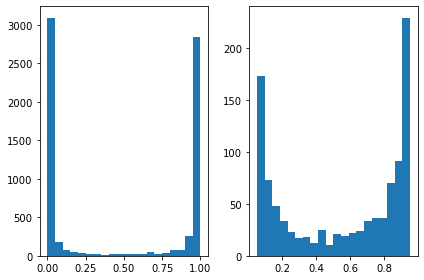

In [9]:
fig, ax = plt.subplots(1, 2, sharey=False, tight_layout=True)

ax[0].hist(firstname_with_sex['ratio'], bins=20)
ax[1].hist(firstname_with_sex['ratio'], bins=20, range=(0.05, 0.95))
ax[0]

<AxesSubplot:>

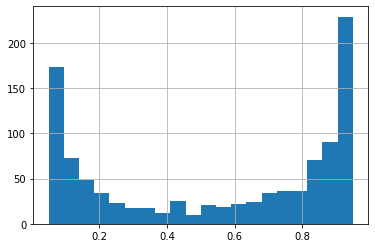

In [10]:
firstname_with_sex['ratio'].hist(bins=20, range=(0.05, 0.95),log=False)

In [11]:
transcriptions_with_sex.tail()

,subject_line,groundtruth,prediction,sex
236,1d92738a-cffe-4aee-ab10-db04c37f7405,surname: Burlurut firstname: Pétronille occupa...,nom: Burlurut prénom: Gihromille date_naissanc...,femme
237,09440055-7972-4135-a537-e6c5a1f2aeb2,surname: Combey firstname: Alexandre occupatio...,nom: Comberf prénom: Alexandre date_naissance:...,homme
238,4d387278-12c3-410c-bdf0-c5c603479764,surname: Collin firstname: Marguerite occupati...,nom: Collin prénom: Marguerite date_naissance:...,femme
239,623b95de-f87c-4844-a7f7-361088eed83a,surname: Dumont firstname: Etienne link: fils ...,nom: Dumont prénom: Etienne date_naissance: 19...,homme
240,26d7839c-16a1-486e-9736-83e500fb72e5,surname: Renaut firstname: Antoinette link: be...,nom: Renaut prénom: Antoinette date_naissance:...,femme


In [67]:
transcriptions_with_sex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subject_line  241 non-null    object
 1   groundtruth   241 non-null    object
 2   prediction    241 non-null    object
 3   sex           241 non-null    object
dtypes: object(4)
memory usage: 7.7+ KB


In [32]:
result = []

def get_attributes(string):
    # Iteriere durch jeden Teil des gesplitteten Strings
    parts = string.split(':')
    for part in parts:
        # Extrahiere das erste Wort des aktuellen Teils und füge es zur Ergebnisliste hinzu
        #print("Teil: ", part)
        first_word = part.split()
        result.append(first_word[len(first_word)-1])

for groundtruth in transcriptions_with_sex.prediction:
    get_attributes(groundtruth)

mylist = result
mylist = list(dict.fromkeys(mylist))
print(mylist)

['nom', 'prénom', 'date_naissance', 'lieux_naissance', '"', 'employeur', 'ahef', 'relation', 'd', 'profession', "''", 'métro', 'F', 'id', '18374', 'P', '1834', 'état_civil', 'femme', 'Su', 'chef', 'Chef', 'ch', 'prof', 'aa', 'Domistique', 'patron', 'ep', 'enfant', 'Crousier', '?2136', 'fils', 'f', 'Ep', 'fosgeron', 'ouvaie', 'Ch', 'néant', '21399', 'd°', "'", 'epre', 'patron!18371', 'Machelo', 'argentière', '"\'', 'Ed', 'fille', 'p', 'fimme', 'Niant', 'Maronnier', 'ferma', 'sp', 'fonmer', 'enttinateur', 'reaix', 'Cheus)', '!21399', 'io', 'foume', 'sormerce', 'S', 'Creyre', 'professeur', 'noant', 'Crousiere', 'a', 'Enfant', 'M', 'Par', 'Bonnechon', 'brue', 'Plive', 'pof', 'Genrie', 'Lefebvre', 'sans', 'Labrye', 'pe', 'D', 'oabrienson', 'enf', 'patissier', 'par', '1opne', 'mère', 'éducation', 'Gre', 'bessinateur', 'Lameau', 'Lansait', 'emllisat', 'Vitant', 'camprof', 'Margottad', 'métag', 'repasseuse', 'pla', 'famille', 'cultinière', 'euregestrement', '"d', '155a', 'chausne', 'Bru', 'fom

In [29]:
attributes_list = ['surname', 'firstname', 'occupation', 'link', 'age', 'civil_status', 'birth_date', 'observation', 'employer']
attributes_list_doublepoint = ['surname:', 'firstname:', 'occupation:', 'link:', 'age:', 'civil_status:', 'birth_date:', 'observation:', 'employer:', 'lob:']

In [35]:
import re

# Sample data
data = "surname: Burlurut firstname: Pétronille occupation: sans profession link: épouse age: 61 ans"
attributes = ['surname:', 'firstname:', 'occupation:', 'link:', 'age:', 'civil_status:', 'birth_date:', 'observation:', 'employer:']

# Initialize a dictionary to store the extracted values
extracted_values = {}

# Iterate through each attribute
for attribute in attributes:
    # Find the index of the attribute in the data
    start_index = data.find(attribute)
    if start_index != -1:  # If attribute is found
        # Find the end index of the value (next attribute or end of string)
        end_index = data.find(attributes[attributes.index(attribute) + 1]) if attributes.index(attribute) + 1 < len(attributes) else len(data)
        # Extract the value using regular expression
        value = re.search(rf"{re.escape(attribute)}\s*(.*?)(?=\s*{re.escape(attributes[attributes.index(attribute) + 1])}|$)", data[start_index:end_index])
        if value:
            extracted_values[attribute.strip(':')] = value.group(1).strip()

# Print the extracted values
print(extracted_values)


{'surname': 'Burlurut', 'firstname': 'Pétronille', 'occupation': 'sans profession', 'link': 'épouse', 'age': '61 an'}


In [42]:
df = pd.DataFrame([extracted_values])

# Transpose the DataFrame to have attributes as columns
df = df.transpose().reset_index()
df.columns = ['Attribute', 'Value']
df.transpose().head()

,0,1,2,3,4
Attribute,surname,firstname,occupation,link,age
Value,Burlurut,Pétronille,sans profession,épouse,61 an


In [61]:
groundtruth_list = transcriptions_with_sex.groundtruth.tolist()
groundtruth_list

['surname: Chardon firstname: Marie occupation: idem link: fille age: 30 ',
 'surname: Lhopital firstname: Louis-Jean occupation: sp link: chef age: 67 ',
 'surname: Papin firstname: Marie occupation: idem link: idem employer: idem age: 15 ',
 'surname: Lavocat firstname: Marie link: femme birth_date: 1875 lob: Rigny ',
 'surname: Benne firstname: Marguerite age: 78 ',
 'surname: Roy firstname: Antoine occupation: Métayer patron link: chef de ménage age: 51 ans ',
 'surname: Bizet firstname: Louis link: idem age: 9 ',
 'surname: Garitat firstname: Jules link: fils age: 12 ',
 'surname: Souche firstname: Maria occupation: idem link: idem age: 4 mois ',
 'surname: Guichou firstname: Elisabeth occupation: néant link: femme age: 28 ',
 'surname: Copain firstname: Jacques occupation: idem link: idem age: 12 ',
 'surname: Aubouer firstname: Ernestine occupation: néant link: enfant age: 13 ans ',
 'surname: Raduron firstname: Anne link: Sa femme age: 51 birth_date: 1835 ',
 'surname: Benne fi

In [75]:
data = {
    'attributes_column': groundtruth_list
}
df = pd.DataFrame(data)
df

,attributes_column
0,surname: Chardon firstname: Marie occupation: ...
1,surname: Lhopital firstname: Louis-Jean occupa...
2,surname: Papin firstname: Marie occupation: id...
3,surname: Lavocat firstname: Marie link: femme ...
4,surname: Benne firstname: Marguerite age: 78
...,...
236,surname: Burlurut firstname: Pétronille occupa...
237,surname: Combey firstname: Alexandre occupatio...
238,surname: Collin firstname: Marguerite occupati...
239,surname: Dumont firstname: Etienne link: fils ...


In [94]:
import pandas as pd
import re

# Sample DataFrame
data = {
    'attributes_column': groundtruth_list
}
df = pd.DataFrame(data)

# Attributes list
attributes = ['surname:', 'firstname:', 'occupation:', 'link:', 'age:', 'civil_status:', 'birth_date:', 'observation:', 'employer:', 'lob:']

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame(columns=attributes)
i = 0

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Initialize a dictionary to store the extracted values for the current row
    extracted_values = {}
    # Extract values for each attribute
    for attribute in attributes:
        # Find the index of the attribute in the current row's string
        start_index = row['attributes_column'].find(attribute)
        if start_index != -1:  # If attribute is found
            # Find the end index of the value (next attribute or end of string)
            end_index = row['attributes_column'].find(attributes[attributes.index(attribute) + 1]) if attributes.index(attribute) + 1 < len(attributes) else len(row['attributes_column'])
            # Extract the value using regular expression
            print(i)
            i += 1
            if i == 20:
                break
            value = re.search(rf"{re.escape(attribute)}\s*(.*?)(?=\s*{re.escape(attributes[attributes.index(attribute) + 1])}|$)", row['attributes_column'][start_index:end_index])
            if value:
                extracted_values[attribute.strip(':')] = value.group(1).strip()
        else:
            # If attribute is not found, set the value as None
            extracted_values[attribute.strip(':')] = None
    # Append the extracted values for the current row to the result DataFrame
    result_df = result_df.append(extracted_values, ignore_index=True)
    if i == 20:
        break

result_df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/3261572402.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(extracted_values, ignore_index=True)
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/3261572402.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(extracted_values, ignore_index=True)
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/3261572402.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(extracted_values, ignore_index=True)
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/3261572402.py:40: FutureWarning: The frame.append method is deprecated and will be 

,surname:,firstname:,occupation:,link:,age:,civil_status:,birth_date:,observation:,employer:,lob:,age,birth_date,civil_status,employer,firstname,link,lob,observation,occupation,surname
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,None,None,None,Marie,fille,None,None,idem,Chardon
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67,None,None,None,Louis-Jean,chef,None,None,sp,Lhopital
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,None,None,idem age: 15,Marie,idem employer: idem,None,None,idem,Papin
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,NaN,Marie link: femme birth_date: 1875 lob: Rigny,femme birth_date: 1875 lob: Rigny,NaN,NaN,None,Lavocat


In [91]:
result_df

,surname:,firstname:,occupation:,link:,age:,civil_status:,birth_date:,observation:,employer:,lob:,age,birth_date,civil_status,employer,firstname,link,lob,observation,occupation,surname
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,None,None,None,Marie,fille,None,None,idem,Chardon
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67,None,None,None,Louis-Jean,chef,None,None,sp,Lhopital
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,None,None,idem age: 15,Marie,idem employer: idem,None,None,idem,Papin


In [59]:
result_df

,surname:,firstname:,occupation:,link:,age:,civil_status:,birth_date:,observation:,employer:,age,birth_date,civil_status,employer,firstname,link,observation,occupation,surname
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61 an,None,None,None,Pétronille,épouse,None,sans profession,Burlurut
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35 year,None,None,None,John,spouse,None,engineer,Doe


In [95]:
import pandas as pd
import re

# Sample DataFrame

data = {
    'attributes_column': [
        "surname: Burlurut firstname: Pétronille occupation: sans profession link: épouse age: 61 ans",
        "surname: Doe firstname: John occupation: engineer link: spouse age: 35 years",
        "surname: Charrier firstname: Marguerite occupation: sans prof link: épouse age: 31",
        "surname: Roy firstname: Antoine occupation: Métayer patron link: chef de ménage age: 51 ans",
        "surname: Parrot firstname: Jean occupation: journalier link: chef age: 33",
        "surname: Daniel firstname: Marguerite occupation: domestique age: 15",
        "surname: Benne firstname: Annette link: femme age: 46"
#        "surname: Martin firstname: Marguerite occupation: idem link: épouse employer: idem age: 30",
#        "surname: Debouesse firstname: Alexandre occupation: couvreur link: chef employer: patron age: 42"
#        "surname: Martin firstname: Louis occupation: néant link: enfant employer: néant age: 6"
    ]
}

df = pd.DataFrame(data)

# Attributes list
attributes = ['surname:', 'firstname:', 'occupation:', 'link:', 'age:', 'civil_status:', 'birth_date:', 'observation:', 'employer:']

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame(columns=attributes)

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Initialize a dictionary to store the extracted values for the current row
    extracted_values = {}
    # Extract values for each attribute
    for attribute in attributes:
        # Find the index of the attribute in the current row's string
        start_index = row['attributes_column'].find(attribute)
        if start_index != -1:  # If attribute is found
            # Find the end index of the value (next attribute or end of string)
            next_attribute_index = attributes.index(attribute) + 1
            if next_attribute_index < len(attributes):
                end_index = row['attributes_column'].find(attributes[next_attribute_index])
            else:
                end_index = len(row['attributes_column'])
            # Extract the value using regular expression
            value = re.search(rf"{re.escape(attribute)}\s*(.*?)(?=\s*{re.escape(attributes[next_attribute_index])}|$)", row['attributes_column'][start_index:end_index])
            if value:
                extracted_values[attribute.strip(':')] = value.group(1).strip()
        else:
            # If attribute is not found, set the value as None
            extracted_values[attribute.strip(':')] = None
    # Append the extracted values for the current row to the result DataFrame
    result_df = result_df.append(extracted_values, ignore_index=True)

result_df

/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/30212549.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(extracted_values, ignore_index=True)
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/30212549.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(extracted_values, ignore_index=True)
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/30212549.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(extracted_values, ignore_index=True)
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/30212549.py:52: FutureWarning: The frame.append method is deprecated and will be removed 

,surname:,firstname:,occupation:,link:,age:,civil_status:,birth_date:,observation:,employer:,age,birth_date,civil_status,employer,firstname,link,observation,occupation,surname
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61 an,None,None,None,Pétronille,épouse,None,sans profession,Burlurut
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35 year,None,None,None,John,spouse,None,engineer,Doe
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,None,None,None,Marguerite,épouse,None,sans prof,Charrier
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51 an,None,None,None,Antoine,chef de ménage,None,Métayer patron,Roy
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,None,None,None,Jean,chef,None,journalier,Parrot
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,None,None,None,Marguerite,None,None,domestique age: 1,Daniel
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,None,None,None,Annette link: femme age: 4,femme,None,None,Benne


## Bruteforce data split

In [99]:
groundtruth = transcriptions_with_sex.groundtruth
groundtruth

0      surname: Chardon firstname: Marie occupation: ...
1      surname: Lhopital firstname: Louis-Jean occupa...
2      surname: Papin firstname: Marie occupation: id...
3      surname: Lavocat firstname: Marie link: femme ...
4          surname: Benne firstname: Marguerite age: 78 
                             ...                        
236    surname: Burlurut firstname: Pétronille occupa...
237    surname: Combey firstname: Alexandre occupatio...
238    surname: Collin firstname: Marguerite occupati...
239    surname: Dumont firstname: Etienne link: fils ...
240    surname: Renaut firstname: Antoinette link: be...
Name: groundtruth, Length: 241, dtype: object

In [100]:
print(groundtruth[0].split(' '))

['surname:', 'Chardon', 'firstname:', 'Marie', 'occupation:', 'idem', 'link:', 'fille', 'age:', '30', '']


In [102]:
print(combine_strings(groundtruth[0].split(' ')))

['surname:Chardon', 'firstname:Marie', 'occupation:idem', 'link:fille', 'age:30']


In [103]:
list = []
for data in groundtruth:
    list.append(combine_strings(data.split(' ')))

In [104]:
list

[['surname:Chardon',
  'firstname:Marie',
  'occupation:idem',
  'link:fille',
  'age:30'],
 ['surname:Lhopital',
  'firstname:Louis-Jean',
  'occupation:sp',
  'link:chef',
  'age:67'],
 ['surname:Papin',
  'firstname:Marie',
  'occupation:idem',
  'link:idem',
  'employer:idem',
  'age:15'],
 ['surname:Lavocat',
  'firstname:Marie',
  'link:femme',
  'birth_date:1875',
  'lob:Rigny'],
 ['surname:Benne', 'firstname:Marguerite', 'age:78'],
 ['surname:Roy',
  'firstname:Antoine',
  'occupation:Métayerpatron',
  'link:chefdeménage',
  'age:51ans'],
 ['surname:Bizet', 'firstname:Louis', 'link:idem', 'age:9'],
 ['surname:Garitat', 'firstname:Jules', 'link:fils', 'age:12'],
 ['surname:Souche',
  'firstname:Maria',
  'occupation:idem',
  'link:idem',
  'age:4mois'],
 ['surname:Guichou',
  'firstname:Elisabeth',
  'occupation:néant',
  'link:femme',
  'age:28'],
 ['surname:Copain',
  'firstname:Jacques',
  'occupation:idem',
  'link:idem',
  'age:12'],
 ['surname:Aubouer',
  'firstname:Ernest

In [106]:
df = pd.DataFrame({'col':list})
df

,col
0,"[surname:Chardon, firstname:Marie, occupation:..."
1,"[surname:Lhopital, firstname:Louis-Jean, occup..."
2,"[surname:Papin, firstname:Marie, occupation:id..."
3,"[surname:Lavocat, firstname:Marie, link:femme,..."
4,"[surname:Benne, firstname:Marguerite, age:78]"
...,...
236,"[surname:Burlurut, firstname:Pétronille, occup..."
237,"[surname:Combey, firstname:Alexandre, occupati..."
238,"[surname:Collin, firstname:Marguerite, occupat..."
239,"[surname:Dumont, firstname:Etienne, link:fils,..."


In [107]:
def combine_strings(lst):
    combined_list = []
    i = 0
    while i < len(lst):
        if lst[i].endswith(':'):
            combined_string = lst[i]
            i += 1
            while i < len(lst) and not lst[i].endswith(':'):
                combined_string += lst[i]
                i += 1
            combined_list.append(combined_string)
        else:
            combined_list.append(lst[i])
            i += 1
    return combined_list

In [111]:
# Define an empty dictionary to hold the key-value pairs
dict_data = {}

# Iterate through each sublist in data
for sublist in list:
    # Iterate through each key-value pair in the sublist
    for item in sublist:
        # Split the key-value pair by ":"
        key, value = item.split(":")
        # If the key already exists in the dictionary, append the value to the existing list
        if key in dict_data:
            dict_data[key].append(value)
        # If the key doesn't exist, create a new list with the value
        else:
            dict_data[key] = [value]

# Determine the maximum length of the lists
max_length = max(len(lst) for lst in dict_data.values())

# Pad the lists with None values to make them all the same length
for key in dict_data:
    dict_data[key] += [None] * (max_length - len(dict_data[key]))

# Convert the dictionary to a DataFrame
df_dict = pd.DataFrame(dict_data)
df_dict

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation
0,Chardon,Marie,idem,fille,30,idem,1875,Rigny,Hommemarié,x
1,Lhopital,Louis-Jean,sp,chef,67,néant,1835,Paris,Garçon,None
2,Papin,Marie,idem,idem,15,idem,1841,Paris,Garçon,None
3,Lavocat,Marie,Métayerpatron,femme,78,patron,1896,Saint-AvitPuy-De-Dome,None,None
4,Benne,Marguerite,idem,chefdeménage,51ans,idem,1885,Coulanges,None,None
...,...,...,...,...,...,...,...,...,...,...
235,Burlurut,Pétronille,None,None,None,None,None,None,None,None
236,Combey,Alexandre,None,None,None,None,None,None,None,None
237,Collin,Marguerite,None,None,None,None,None,None,None,None
238,Dumont,Etienne,None,None,None,None,None,None,None,None


In [112]:
df_groundtruth = df_dict

In [114]:
df_groundtruth['sex'] = transcriptions_with_sex.sex
df_groundtruth

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation,sex
0,Chardon,Marie,idem,fille,30,idem,1875,Rigny,Hommemarié,x,femme
1,Lhopital,Louis-Jean,sp,chef,67,néant,1835,Paris,Garçon,None,homme
2,Papin,Marie,idem,idem,15,idem,1841,Paris,Garçon,None,femme
3,Lavocat,Marie,Métayerpatron,femme,78,patron,1896,Saint-AvitPuy-De-Dome,None,None,femme
4,Benne,Marguerite,idem,chefdeménage,51ans,idem,1885,Coulanges,None,None,femme
...,...,...,...,...,...,...,...,...,...,...,...
235,Burlurut,Pétronille,None,None,None,None,None,None,None,None,femme
236,Combey,Alexandre,None,None,None,None,None,None,None,None,femme
237,Collin,Marguerite,None,None,None,None,None,None,None,None,homme
238,Dumont,Etienne,None,None,None,None,None,None,None,None,femme


In [115]:
transcriptions_with_sex

,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme
...,...,...,...,...
236,1d92738a-cffe-4aee-ab10-db04c37f7405,surname: Burlurut firstname: Pétronille occupa...,nom: Burlurut prénom: Gihromille date_naissanc...,femme
237,09440055-7972-4135-a537-e6c5a1f2aeb2,surname: Combey firstname: Alexandre occupatio...,nom: Comberf prénom: Alexandre date_naissance:...,homme
238,4d387278-12c3-410c-bdf0-c5c603479764,surname: Collin firstname: Marguerite occupati...,nom: Collin prénom: Marguerite date_naissance:...,femme
239,623b95de-f87c-4844-a7f7-361088eed83a,surname: Dumont firstname: Etienne link: fils ...,nom: Dumont prénom: Etienne date_naissance: 19...,homme


In [163]:
strings = [
    "surname: Chardon firstname: Marie occupation: idem link: fille age: 30",
    "surname: Lhopital firstname: Louis Jean occupation: sp link: chef age: 67",
    "surname: Lavocat firstname: Marie link: femme birth_date: 1875 lob: Rigny",
]

def key_value(s):
    key = None
    value = []
    for token in s.split():
        if token[-1] == ":":
            if key is not None:
                yield key, " ".join(value)
            key = token[:-1]
            value = []
        else:
            value.append(token)
    if key is not None:
        yield key, " ".join(value)

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation
0,Chardon,Marie,idem,fille,30,NaN,NaN,NaN,NaN,NaN
1,Lhopital,Louis-Jean,sp,chef,67,NaN,NaN,NaN,NaN,NaN
2,Papin,Marie,idem,idem,15,idem,NaN,NaN,NaN,NaN
3,Lavocat,Marie,NaN,femme,NaN,NaN,1875,Rigny,NaN,NaN
4,Benne,Marguerite,NaN,NaN,78,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Pétronille,sans profession,épouse,61 ans,NaN,NaN,NaN,NaN,NaN
237,Combey,Alexandre,idem,son fils,39,NaN,NaN,NaN,NaN,NaN
238,Collin,Marguerite,idem,épouse,38,idem,NaN,NaN,NaN,NaN
239,Dumont,Etienne,NaN,fils,NaN,NaN,1900,idem,NaN,NaN


In [164]:
DataFrame({key: value for key, value in key_value(string)} for string in transcriptions_with_sex.groundtruth).to_csv('groundtruth.csv', index = False)
df = DataFrame({key: value for key, value in key_value(string)} for string in transcriptions_with_sex.prediction).to_csv('prediction.csv', index = False)
df

In [166]:
df = DataFrame({key: value for key, value in key_value(string)} for string in transcriptions_with_sex.groundtruth)
df

,surname,firstname,occupation,link,age,employer,birth_date,lob,civil_status,observation
0,Chardon,Marie,idem,fille,30,NaN,NaN,NaN,NaN,NaN
1,Lhopital,Louis-Jean,sp,chef,67,NaN,NaN,NaN,NaN,NaN
2,Papin,Marie,idem,idem,15,idem,NaN,NaN,NaN,NaN
3,Lavocat,Marie,NaN,femme,NaN,NaN,1875,Rigny,NaN,NaN
4,Benne,Marguerite,NaN,NaN,78,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
236,Burlurut,Pétronille,sans profession,épouse,61 ans,NaN,NaN,NaN,NaN,NaN
237,Combey,Alexandre,idem,son fils,39,NaN,NaN,NaN,NaN,NaN
238,Collin,Marguerite,idem,épouse,38,idem,NaN,NaN,NaN,NaN
239,Dumont,Etienne,NaN,fils,NaN,NaN,1900,idem,NaN,NaN


### First models

In [139]:
def train_test(input, target, test_size):
    X = input
    le = LabelEncoder()
    y = le.fit_transform(target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

#### Vectorizer

In [155]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [169]:
tfidf_vect = TfidfVectorizer()
bow_vect = CountVectorizer()

In [ ]:
train_test(transcriptions_with_sex.groundtruth, transcriptions_with_sex.sex)
train_test(tfidf_vect.fit_transform(transcriptions_with_sex.groundtruth), transcriptions_with_sex.sex)

In [142]:
vectorizers = {
    "BOW": bow_vect,
    "TFIDF": tfidf_vect
}

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier()
    #'LightGBM': LGBMClassifier()
}

In [159]:
X_train, X_test, y_train, y_test = train_test(transcriptions_with_sex.groundtruth, transcriptions_with_sex.sex, 0.2)
target_names = ['male', 'female', 'ambig']

In [160]:
results_df = pd.DataFrame(columns=['Vectorizer', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

for vec_name, vectorizer in vectorizers.items():
    # Fit and transform vectorizer on training data
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Iterate over models
    for model_name, model in models.items():
        # Fit model on vectorized data
        model.fit(X_train_vec, y_train)

        # Make predictions
        y_pred = model.predict(X_test_vec)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        roc_auc = roc_auc_score(y_test, y_pred)

        # Append results to dataframe
        results_df = results_df.append({'Vectorizer': vec_name,
                                        'Model': model_name,
                                        'Accuracy': accuracy,
                                        'Precision': precision,
                                        'Recall': recall,
                                        'F1-Score': f1,
                                        'ROC-AUC': roc_auc},
                                        ignore_index=True)
        #print(classification_report(y_test, y_pred))

# Display results dataframe
print("Results for Surname and Firstname Vectorization:")
display(results_df)

/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/1490417571.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Vectorizer': vec_name,
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/1490417571.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Vectorizer': vec_name,
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/1490417571.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Vectorizer': vec_name,
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/1490417571.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

Results for Surname and Firstname Vectorization:


/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/1490417571.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Vectorizer': vec_name,


,Vectorizer,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,BOW,Logistic Regression,0.836735,0.857143,0.782609,0.818182,0.833612
1,BOW,Random Forest,0.877551,0.904762,0.826087,0.863636,0.874582
2,BOW,SVM,0.816327,0.818182,0.782609,0.8,0.814381
3,BOW,XGBoost,0.897959,0.909091,0.869565,0.888889,0.896321
4,TFIDF,Logistic Regression,0.897959,0.95,0.826087,0.883721,0.893813
5,TFIDF,Random Forest,0.857143,0.833333,0.869565,0.851064,0.85786
6,TFIDF,SVM,0.918367,0.952381,0.869565,0.909091,0.915552
7,TFIDF,XGBoost,0.734694,0.708333,0.73913,0.723404,0.73495


In [172]:
tfidf_firstname = tfidf_vect.fit_transform(df.firstname.values.astype('U'))
tfidf_firstname

<241x87 sparse matrix of type '<class 'numpy.float64'>'
	with 249 stored elements in Compressed Sparse Row format>

In [158]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

le = LabelEncoder()
y = le.fit_transform(transcriptions_with_sex.sex)

# Reset results dataframe for k-fold cross-validation
results_df_kfold = pd.DataFrame()

for vec_name, vectorizer in vectorizers.items():
    # Fit and transform vectorizer on full data
    X_vec = vectorizer.fit_transform(X)

    # Iterate over models
    for model_name, model in models.items():
        # Perform k-fold cross-validation
        cv_scores = cross_val_score(model, X_vec, y, cv=k_fold, scoring='accuracy', error_score='raise')

        # Calculate mean and standard deviation of cross-validation scores
        mean_accuracy = cv_scores.mean()
        std_accuracy = cv_scores.std()

        # Append results to dataframe
        results_df_kfold = results_df_kfold.append({'Vectorizer': vec_name,
                                                    'Model': model_name,
                                                    'Mean Accuracy': mean_accuracy,
                                                    'Std Accuracy': std_accuracy},
                                                   ignore_index=True)

# Display results dataframe for k-fold cross-validation
print("\nResults for Surname and Firstname Vectorization with k-fold cross-validation:")
display(results_df_kfold)

/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/1423796153.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_kfold = results_df_kfold.append({'Vectorizer': vec_name,
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/1423796153.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_kfold = results_df_kfold.append({'Vectorizer': vec_name,
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/1423796153.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_kfold = results_df_kfold.append({'Vectorizer': vec_name,
/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/1423796153.py:23: FutureWarning: The frame.append method is deprecated and wi


Results for Surname and Firstname Vectorization with k-fold cross-validation:


/var/folders/n_/mj2qn5sd20lb04k5gcvn8fbr0000gn/T/ipykernel_21919/1423796153.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_kfold = results_df_kfold.append({'Vectorizer': vec_name,


,Vectorizer,Model,Mean Accuracy,Std Accuracy
0,BOW,Logistic Regression,0.854762,0.018672
1,BOW,Random Forest,0.842347,0.031028
2,BOW,SVM,0.825850,0.033046
3,BOW,XGBoost,0.854762,0.045659
4,TFIDF,Logistic Regression,0.859014,0.030089
5,TFIDF,Random Forest,0.821429,0.039168
6,TFIDF,SVM,0.850765,0.029706
7,TFIDF,XGBoost,0.792517,0.045675
